zsh:1: missing end of string


Note: you may need to restart the kernel to use updated packages.


In [9]:
import scanpy as sc
import numpy as np

import milopy
import milopy.core as milo

In [26]:
adata = sc.datasets.pbmc3k_processed()
adata

#adata = sc.read_h5ad("/Users/Ali/Desktop/Mehtonen et al./GSE148218_RAW/adata_rb.h5ad")
#adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/Ali/anaconda3/envs/MEDI7281/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


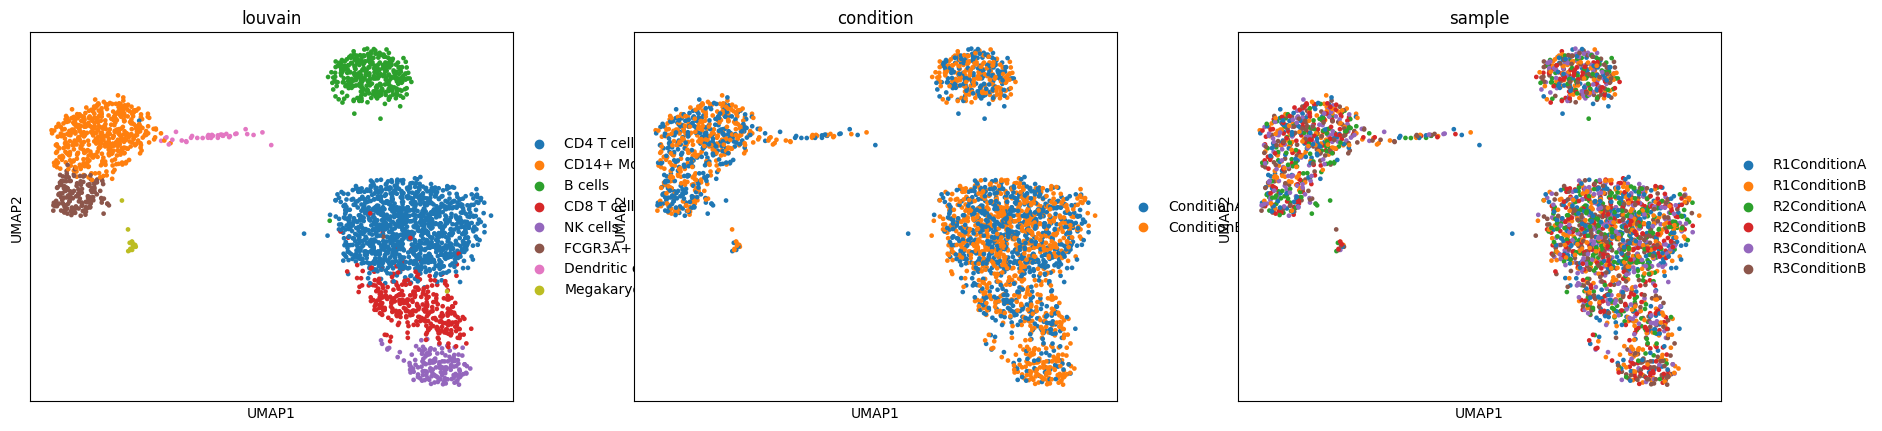

In [27]:
## Simulate experimental condition ##
adata.obs["condition"] = np.random.choice(["ConditionA", "ConditionB"], size=adata.n_obs, p=[0.5,0.5])
# we simulate differential abundance in NK cells
DA_cells = adata.obs["louvain"] == "NK cells"
adata.obs.loc[DA_cells, "condition"] = np.random.choice(["ConditionA", "ConditionB"], size=sum(DA_cells), p=[0.2,0.8])

## Simulate replicates ##
adata.obs["replicate"] = np.random.choice(["R1", "R2", "R3"], size=adata.n_obs)
adata.obs["sample"] = adata.obs["replicate"] + adata.obs["condition"]

sc.pl.umap(adata, color=["louvain","condition", "sample"])

In [28]:
## Build KNN graph
sc.pp.neighbors(adata, n_neighbors=10)

## Assign cells to neighbourhoods
milo.make_nhoods(adata)

## Count cells from each sample in each nhood
milo.count_nhoods(adata, sample_col="sample")

## Test for differential abundance between conditions
milo.DA_nhoods(adata, design="~ condition")

## Check results
milo_results = adata.uns["nhood_adata"].obs
milo_results

  statmod package required but is not installed



RRuntimeError: Error in fitFDistRobustly(var, df1 = df, covariate = covariate, winsor.tail.p = winsor.tail.p) : 
  statmod package required but is not installed


In [29]:
milopy.utils.build_nhood_graph(adata)
milopy.plot.plot_nhood_graph(adata, alpha=0.2, min_size=5)

KeyError: 'logFC'